# Decision trees & boosted decision trees

Look at lending club loan data to make a decision tree for safe and risky loans.

1. Make small and large trees, assess performance, and visualize
2. Boost decision stumps and assess performance

In [1]:
import os, sys, csv, string

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from __future__ import division # 5/2 = 2.5

%matplotlib inline

# Initial data formatting

1. Read in data (lending-club-data.csv)

2. Change target feature to from "risky loans" (0,1) to "safe loans" (-1,+1)

3. Select subset of features for tree

4. Sample risky/safe classes to ensure balance 

### Read in data

In [2]:
df1 = pd.read_csv('lending-club-data.csv')
#df1 = df1.fillna({'review':''})  # fill in N/A's in the review column
df1.head()
#print len(df1)    

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


### create "safe loans" feature with +-1 as values

In [3]:
#bad_loans = 1 for risky, 0 for safe. rename to 'safe_loans' = +-1
df1['safe_loans'] = df1['bad_loans'].apply(lambda x : +1 if x==0 else -1)
del df1['bad_loans']

In [4]:
#safe loans?

safe = 0
for loan in df1['safe_loans']:
    if loan == 1:
        safe += 1

safe = safe/len(df1)
        
print "Safe: ", safe
print "Risky: ", 1-safe 

Safe:  0.811185331996
Risky:  0.188814668004


### Select subset of data features and remake dataframe

In [5]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = df1[features + [target]]

In [6]:
print loans[0:5]

  grade sub_grade  short_emp  emp_length_num home_ownership    dti  \
0     B        B2          0              11           RENT  27.65   
1     C        C4          1               1           RENT   1.00   
2     C        C5          0              11           RENT   8.72   
3     C        C1          0              11           RENT  20.00   
4     A        A4          0               4           RENT  11.20   

          purpose        term  last_delinq_none  last_major_derog_none  \
0     credit_card   36 months                 1                      1   
1             car   60 months                 1                      1   
2  small_business   36 months                 1                      1   
3           other   36 months                 0                      1   
4         wedding   36 months                 1                      1   

   revol_util  total_rec_late_fee  safe_loans  
0        83.7                0.00           1  
1         9.4                0.00     

### Generate dataset that balances safe and risky loans 

In [7]:
#want to balance classes when training classifier
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
print "Number of safe loans  : %s" % len(safe_loans_raw)
print "Number of risky loans : %s" % len(risky_loans_raw)

Number of safe loans  : 99457
Number of risky loans : 23150


In [8]:
#undersample safe loans
percentage = len(risky_loans_raw)/len(safe_loans_raw)
print percentage

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=percentage, random_state=1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

0.232763908021


# Decision Tree 

1. Convert data to one-hot encoding (create feature for every category, so that the decision tree can make binary decisions for every possibility)

2. Divide data into training (80%) and validation (20%) sets

3. Train a small tree (depth 2) and a large tree (depth 6) on the training data

4. Visualize the small tree 

5. Assess performance of tree models

### One-hot encoding 
Ex.: instead of "home_ownership" with 3 categories "rent, own, mortgage", create three features "home_ownership_rent", "home_ownership_own", "home_ownership_mortgage" that are all (0,1)

In [9]:
#one-hot encode

loans_1hot = pd.get_dummies(loans_data)

### Split data into test and validation subsets (20% validation, 80% train)

In [10]:
#80-20 training, validation split
from sklearn.model_selection import train_test_split
train, test = train_test_split(loans_1hot, test_size = 0.2)

### Train a decision tree with depth 6

In [11]:
from sklearn import tree
tree6 = tree.DecisionTreeClassifier(max_depth=6)

test_targ = test['safe_loans']
train_targ = train['safe_loans']

testX = test.drop('safe_loans', 1)
trainX = train.drop('safe_loans', 1)

decision_tree_model = tree6.fit(trainX, train_targ)

### Train a small decision tree with depth 2

In [12]:
tree2 = tree.DecisionTreeClassifier(max_depth=2)
small_model = tree2.fit(trainX, train_targ)


### Visualize the small tree using graphviz

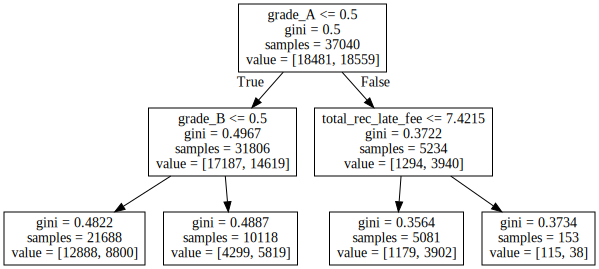

In [13]:
from graphviz import Source


#in-place, no file I/O 
tree_gr = tree.export_graphviz(small_model,out_file=None,feature_names=list(trainX.columns.values))
Source(tree_gr)

#view tree by creating and reading a dot file of the tree

#tree.export_graphviz(small_model,out_file='tree.dot',feature_names=list(trainX.columns.values))
#file = open('tree.dot', 'r') #read dot file
#text=file.read()
#Source(text)

In [ ]:
#6-deep tree, run this cell to visualize
tree_gr6 = tree.export_graphviz(decision_tree_model,out_file=None,feature_names=list(trainX.columns.values))
Source(tree_gr6)

### Tree model performance

In [14]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)))

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred))
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred))

### Depth 6 tree performance

In [15]:
measure_performance(testX,test_targ,decision_tree_model, 
                    show_classification_report=True, 
                    show_confusion_matrix=True)

Accuracy:0.635
Classification report
             precision    recall  f1-score   support

         -1       0.63      0.66      0.64      4669
          1       0.64      0.61      0.62      4591

avg / total       0.64      0.64      0.63      9260

Confusion matrix
[[3067 1602]
 [1777 2814]]


### Depth 2 tree performance

In [16]:
measure_performance(testX,test_targ,small_model, 
                    show_classification_report=True, 
                    show_confusion_matrix=True)

Accuracy:0.619
Classification report
             precision    recall  f1-score   support

         -1       0.60      0.71      0.65      4669
          1       0.64      0.53      0.58      4591

avg / total       0.62      0.62      0.62      9260

Confusion matrix
[[3319 1350]
 [2179 2412]]


# AdaBoost

The accuracy of the decision trees is not very good. Can we do better with boosting?

1. Create a single boosted decision tree from the same training data and assess its performance

2. Scan over number of trees in the boosting to evaluate the evolution of the model accuracy

In [17]:
#AdaBoost

from sklearn import ensemble

aboost = ensemble.AdaBoostClassifier(n_estimators = 100) #classifier is default = decision stump
aboost_model = aboost.fit(trainX, train_targ)

### Boosted tree performance is better:

(slightly, depends on data selection)

In [18]:
measure_performance(testX,test_targ,aboost_model, 
                    show_classification_report=True, 
                    show_confusion_matrix=True)

Accuracy:0.645
Classification report
             precision    recall  f1-score   support

         -1       0.65      0.63      0.64      4669
          1       0.64      0.66      0.65      4591

avg / total       0.65      0.64      0.64      9260

Confusion matrix
[[2959 1710]
 [1579 3012]]


### Scan over number of trees and determine accuracy of model for test and verification datasets

In [19]:
#this cell is slow due to large number of trees to train

n_trees = np.linspace(1, 100, num=50, dtype=int)
#print n_trees

test_acc = []
train_acc = []

for n in n_trees:
    #make the BDT's
    aboost_n = ensemble.AdaBoostClassifier(n_estimators = n) #classifier is default = decision stump
    aboost_model_n = aboost_n.fit(trainX, train_targ)

    # accuracy
    train_accuracy = metrics.accuracy_score(y_true=train_targ, y_pred=aboost_model_n.predict(trainX))
    test_accuracy = metrics.accuracy_score(y_true=test_targ, y_pred=aboost_model_n.predict(testX))
    
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

    

In [20]:
#get accuracy of simple trees (depth 2 and 6) to compare with boosted

small_acc = metrics.accuracy_score(test_targ,small_model.predict(testX))
large_acc = metrics.accuracy_score(test_targ,decision_tree_model.predict(testX))

### Plot the model accuracy vs number of trees on training and verification datasets, compare to simple trees

we see that for more than ~10 trees, the ensemble trees perform better than the single complex tree, but the ensemble performance does not continue to improve much for increasing number of trees. 

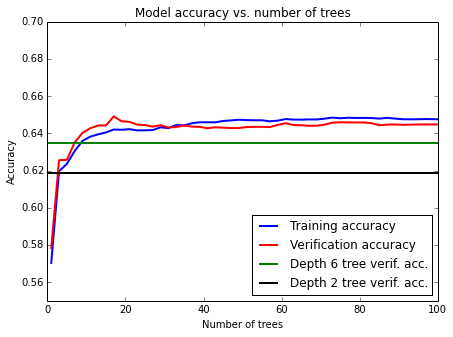

In [21]:
#plot model accuracy for 
# 1. boosted on training data
# 2. boosted on verification data
# 3. Depth 6 tree on verification data
# 4. Depth 2 tree on verification data

plt.rcParams['figure.figsize'] = 7, 5
plt.plot(n_trees, train_acc, 'b-', linewidth=2.0, label='Training accuracy')
plt.plot(n_trees, test_acc, 'r-', linewidth=2.0, label='Verification accuracy')

plt.plot((0, 100), (large_acc, large_acc), 'g-',linewidth=2.0,label='Depth 6 tree verif. acc.')
plt.plot((0, 100), (small_acc, small_acc), 'k-',linewidth=2.0, label='Depth 2 tree verif. acc.')

plt.ylim(0.55,0.7)
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.title("Model accuracy vs. number of trees")

plt.legend(loc='lower right', fancybox=False, shadow=False)